
# Clasificación de Niveles de Obesidad — Pipeline completo
**Descripción:** Notebook que carga `dataset_limpio.csv` (Generado en notebook EDA), realiza preprocesamiento, entrena y compara **RandomForest** y **XGBoost**, ajusta hiperparámetros, evalúa modelos y guarda el mejor pipeline.  


In [ ]:
pip install mlflow


In [ ]:
# Instalar ngrok y MLflow
!pip install pyngrok mlflow

In [ ]:
import joblib
import mlflow
import os
import subprocess
import mlflow.sklearn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyngrok import ngrok
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, learning_curve, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from mlflow.models import infer_signature
from google.colab import userdata, files

print('Librerías cargadas correctamente.')


Librerías cargadas correctamente.


In [ ]:
# Configuración Inicial de MLflow
mlflow.set_experiment("Clasificacion_Niveles_Obesidad_RF")

<Experiment: artifact_location='file:///content/mlruns/591922849470545044', creation_time=1760273392175, experiment_id='591922849470545044', last_update_time=1760273392175, lifecycle_stage='active', name='Clasificacion_Niveles_Obesidad_RF', tags={}>

In [ ]:
path = 'dataset_limpio.csv'
df = pd.read_csv(path)


print('Dimensiones:', df.shape)
display(df.head())


Dimensiones: (2153, 17)


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,normal_weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,normal_weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,normal_weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,overweight_level_i
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,overweight_level_ii


In [ ]:
# Inspección rápida
print(df.info())
print('\nDistribución por columnas:\n', df.describe(include='all').T)

# Detectar columna objetivo
target_col = 'NObeyesdad' if 'NObeyesdad' in df.columns else df.columns[-1]
print('\nColumna objetivo asumida:', target_col)

# Codificar target
if df[target_col].dtype == 'object' or str(df[target_col].dtype).startswith('category'):
    # Convertir a tipo category y obtener los nombres de las categorías
    df[target_col] = df[target_col].astype('category')
    clases_reales = df[target_col].cat.categories
    # Convertir a códigos numéricos para el entrenamiento
    df[target_col] = df[target_col].astype('category').cat.codes
    print('Objetivo codificado. Clases:', df[target_col].unique())
    print('Nombres de Clases (clases_reales):', clases_reales.tolist())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2153 entries, 0 to 2152
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2153 non-null   object 
 1   Age                             2153 non-null   float64
 2   Height                          2153 non-null   float64
 3   Weight                          2153 non-null   float64
 4   family_history_with_overweight  2153 non-null   object 
 5   FAVC                            2153 non-null   object 
 6   FCVC                            2153 non-null   float64
 7   NCP                             2153 non-null   float64
 8   CAEC                            2153 non-null   object 
 9   SMOKE                           2153 non-null   object 
 10  CH2O                            2153 non-null   float64
 11  SCC                             2153 non-null   object 
 12  FAF                             21

In [ ]:
# Feature engineering: crear IMC (BMI)
if set(['Height','Weight']).issubset(df.columns):
    df['BMI'] = df['Weight'] / ((df['Height']/100)**2)
    print('Se creó la variable BMI.')
else:
    print('Height/Weight no encontrados; saltando creación de BMI.')

display(df.head())


Se creó la variable BMI.


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,BMI
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,1,243865.264441
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,1,242382.271468
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,1,237654.320988
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,5,268518.518519
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,6,283423.810125


In [ ]:
# Preparar X,y & preprocesamiento
mapping_names = {i: f"{i}-{name}" for i, name in enumerate(clases_reales)}
X = df.drop(columns=[target_col])
y = df[target_col]

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category','bool']).columns.tolist()

print('Numéricas:', num_cols)
print('Categóricas:', cat_cols)

num_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
cat_pipe = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])
preproc = ColumnTransformer([('num', num_pipe, num_cols), ('cat', cat_pipe, cat_cols)], remainder='drop')


Numéricas: ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'BMI']
Categóricas: ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']


In [ ]:
# División train/test estratificada
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print('Train:', X_train.shape, 'Test:', X_test.shape)
print('\nDistribución (train):\n', pd.Series(y_train).map(mapping_names).value_counts(normalize=True))


Train: (1722, 17) Test: (431, 17)

Distribución (train):
 NObeyesdad
2-obesity_type_i         0.174216
4-obesity_type_iii       0.151568
3-obesity_type_ii        0.140534
5-overweight_level_i     0.137631
6-overweight_level_ii    0.135889
1-normal_weight          0.133566
0-insufficient_weight    0.126597
Name: proportion, dtype: float64


In [ ]:
# RandomForest baseline
target_names_format = [f"{i}-{name}" for i, name in enumerate(clases_reales)]
rf_pipe = Pipeline([('pre', preproc),
                    ('clf', RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, class_weight='balanced'))])
# MLFLOW START: RandomForest
with mlflow.start_run(run_name="RandomForest_Baseline"):
    mlflow.log_param("model_type", "RandomForest")
    # Registra los hiperparámetros del clasificador
    mlflow.log_params(rf_pipe.named_steps['clf'].get_params())
    mlflow.log_param("smote_applied", False)

    rf_pipe.fit(X_train, y_train)
    pred_rf = rf_pipe.predict(X_test)

    # 1. Log Metrics: Accuracy y Classification Report (weighted avg)
    accuracy = accuracy_score(y_test, pred_rf)
    # Usamos output_dict=True para capturar métricas programáticamente
    report = classification_report(y_test, pred_rf, target_names=target_names_format, output_dict=True)

    mlflow.log_metric("test_accuracy", accuracy)
    mlflow.log_metric("rf_precision_weighted", report['weighted avg']['precision'])
    mlflow.log_metric("rf_recall_weighted", report['weighted avg']['recall'])
    mlflow.log_metric("rf_f1_weighted", report['weighted avg']['f1-score'])

    # 2. Log Underfitting/Overfitting Metrics (Se loggea el score del pipe)
    train_score = rf_pipe.score(X_train, y_train)
    test_score = rf_pipe.score(X_test, y_test)
    gap = train_score - test_score

    mlflow.log_metric("train_score", train_score)
    mlflow.log_metric("test_score_ov_uf", test_score)
    mlflow.log_metric("gap_overfitting", gap)

    # Log model y la firma
    mlflow.sklearn.log_model(rf_pipe, "random_forest_model", signature=infer_signature(X_test, pred_rf))

    print('RandomForest - Accuracy:', accuracy)
    print()
    print(classification_report(y_test, pred_rf, target_names=target_names_format))
    print()
    print('Confusion matrix:\\n', confusion_matrix(y_test, pred_rf))
#MLFLOW END: RandomForest

2025/10/12 13:49:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


RandomForest - Accuracy: 0.9582366589327146

                       precision    recall  f1-score   support

0-insufficient_weight       0.98      0.98      0.98        54
      1-normal_weight       0.90      0.98      0.94        58
     2-obesity_type_i       0.96      0.91      0.93        75
    3-obesity_type_ii       0.98      0.97      0.98        61
   4-obesity_type_iii       0.97      0.97      0.97        65
 5-overweight_level_i       0.97      0.97      0.97        60
6-overweight_level_ii       0.95      0.95      0.95        58

             accuracy                           0.96       431
            macro avg       0.96      0.96      0.96       431
         weighted avg       0.96      0.96      0.96       431


Confusion matrix:\n [[53  1  0  0  0  0  0]
 [ 1 57  0  0  0  0  0]
 [ 0  2 68  0  1  1  3]
 [ 0  1  0 59  1  0  0]
 [ 0  0  1  1 63  0  0]
 [ 0  1  1  0  0 58  0]
 [ 0  1  1  0  0  1 55]]


In [ ]:
# XGBoost con SMOTE y RandomizedSearchCV
#num_classes = len(np.unique(y))
xgb_pipe_smote = ImbPipeline([('pre', preproc),
                        ('smote', SMOTE(random_state=42)),
                        ('clf', XGBClassifier(objective='multi:softprob',
                                              #use_label_encoder=False,
                                              eval_metric='mlogloss',
                                              random_state=42))#,
                                              #num_class=num_classes))
                        ])

param_dist = {
    'clf__n_estimators': [100, 200, 400],
    'clf__max_depth': [3, 5, 7],
    'clf__learning_rate': [0.01, 0.05, 0.1],
    'clf__subsample': [0.6, 0.8, 1.0],
    'clf__colsample_bytree': [0.6, 0.8, 1.0],
    'smote__k_neighbors': [1]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = RandomizedSearchCV(xgb_pipe_smote,
                            param_dist,
                            n_iter=20,
                            scoring='accuracy',
                            n_jobs=-1,
                            cv=cv,
                            random_state=42,
                            verbose=2)
print('Iniciando búsqueda aleatoria XGBoost.\n')

search.fit(X_train, y_train)
best_xgb = search.best_estimator_
pred_xgb = best_xgb.predict(X_test)
print('\nMejores parámetros:', search.best_params_)

# MLFLOW START: XGBoost (SMOTE)
with mlflow.start_run(run_name="XGBoost_SMOTE_Tuning"):
    mlflow.log_param("model_type", "XGBoost_SMOTE")
    # Registra los mejores hiperparámetros encontrados
    mlflow.log_params(search.best_params_)

    # 1. Log Metrics: Accuracy y Classification Report (weighted avg)
    accuracy = accuracy_score(y_test, pred_xgb)
    report = classification_report(y_test, pred_xgb, target_names=target_names_format, output_dict=True)

    mlflow.log_metric("test_accuracy", accuracy)
    mlflow.log_metric("xgb_smote_precision_weighted", report['weighted avg']['precision'])
    mlflow.log_metric("xgb_smote_recall_weighted", report['weighted avg']['recall'])
    mlflow.log_metric("xgb_smote_f1_weighted", report['weighted avg']['f1-score'])

    # 2. Log Underfitting/Overfitting Metrics
    train_score = best_xgb.score(X_train, y_train)
    test_score = best_xgb.score(X_test, y_test)
    gap = train_score - test_score

    mlflow.log_metric("train_score", train_score)
    mlflow.log_metric("test_score_ov_uf", test_score)
    mlflow.log_metric("gap_overfitting", gap)

    # Log model y la firma
    mlflow.sklearn.log_model(best_xgb, "xgboost_smote_model", signature=infer_signature(X_test, pred_xgb))

    print('\nXGBoost - Accuracy:', accuracy)
    print()
    print(classification_report(y_test, pred_xgb, target_names=target_names_format))
    print()
    print('Confusion matrix:\\n', confusion_matrix(y_test, pred_xgb))
# MLFLOW END: XGBoost (SMOTE)


Iniciando búsqueda aleatoria XGBoost.

Fitting 5 folds for each of 20 candidates, totalling 100 fits


2025/10/12 13:52:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Mejores parámetros: {'smote__k_neighbors': 1, 'clf__subsample': 0.6, 'clf__n_estimators': 200, 'clf__max_depth': 5, 'clf__learning_rate': 0.1, 'clf__colsample_bytree': 0.6}

XGBoost - Accuracy: 0.9698375870069605

                       precision    recall  f1-score   support

0-insufficient_weight       0.98      0.98      0.98        54
      1-normal_weight       0.95      0.98      0.97        58
     2-obesity_type_i       0.97      0.92      0.95        75
    3-obesity_type_ii       0.98      0.97      0.98        61
   4-obesity_type_iii       0.97      0.98      0.98        65
 5-overweight_level_i       0.97      0.98      0.98        60
6-overweight_level_ii       0.97      0.98      0.97        58

             accuracy                           0.97       431
            macro avg       0.97      0.97      0.97       431
         weighted avg       0.97      0.97      0.97       431


Confusion matrix:\n [[53  1  0  0  0  0  0]
 [ 1 57  0  0  0  0  0]
 [ 0  1 69  0  1  2 

In [ ]:
#XGBoost sin SMOTE
#Extraer los mejores parámetros de XGBoost de la búsqueda anterior
best_params_xgb = {
    k.replace('clf__', ''): v
    for k, v in search.best_params_.items()
    if k.startswith('clf__') and 'k_neighbors' not in k
}

#Entrenar el pipeline sin SMOTE
xgb_simple_pipe = Pipeline(steps=[
    ('pre', preproc),
    ('clf', XGBClassifier(
        **best_params_xgb, # Apply the learned parameters
        objective='multi:softprob',
        eval_metric='mlogloss',
        random_state=42             # Ensure reproducibility
    ))
])


# MLFLOW START: XGBoost (sin SMOTE)
with mlflow.start_run(run_name="XGBoost_NoSMOTE_BestParams"):
    mlflow.log_param("model_type", "XGBoost_NoSMOTE")
    mlflow.log_params(best_params_xgb)
    mlflow.log_param("smote_applied", False)

    xgb_simple_pipe.fit(X_train, y_train)

    # Evaluar el modelo sin SMOTE
    pred_xgb_simple = xgb_simple_pipe.predict(X_test)

    # 1. Log Metrics: Accuracy y Classification Report (weighted avg)
    accuracy = accuracy_score(y_test, pred_xgb_simple)
    report = classification_report(y_test, pred_xgb_simple, target_names=target_names_format, output_dict=True)

    mlflow.log_metric("test_accuracy", accuracy)
    mlflow.log_metric("xgb_simple_precision_weighted", report['weighted avg']['precision'])
    mlflow.log_metric("xgb_simple_recall_weighted", report['weighted avg']['recall'])
    mlflow.log_metric("xgb_simple_f1_weighted", report['weighted avg']['f1-score'])

    # 2. Log Underfitting/Overfitting Metrics
    train_score = xgb_simple_pipe.score(X_train, y_train)
    test_score = xgb_simple_pipe.score(X_test, y_test)
    gap = train_score - test_score

    mlflow.log_metric("train_score", train_score)
    mlflow.log_metric("test_score_ov_uf", test_score)
    mlflow.log_metric("gap_overfitting", gap)

    # Log model y la firma
    mlflow.sklearn.log_model(xgb_simple_pipe, "xgboost_simple_model", signature=infer_signature(X_test, pred_xgb_simple))

    # 5. Mostrar resultados
    print('XGBoost sin SMOTE - Accuracy:', accuracy)
    print()
    print(classification_report(y_test, pred_xgb_simple, target_names=target_names_format))
    print()
    print('Matriz de Confusión:\\n', confusion_matrix(y_test, pred_xgb_simple))
# MLFLOW END: XGBoost (sin SMOTE)

2025/10/12 13:52:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


XGBoost sin SMOTE - Accuracy: 0.9721577726218097

                       precision    recall  f1-score   support

0-insufficient_weight       0.98      1.00      0.99        54
      1-normal_weight       0.98      0.98      0.98        58
     2-obesity_type_i       0.96      0.92      0.94        75
    3-obesity_type_ii       0.98      0.97      0.98        61
   4-obesity_type_iii       0.97      0.98      0.98        65
 5-overweight_level_i       0.97      0.98      0.98        60
6-overweight_level_ii       0.97      0.98      0.97        58

             accuracy                           0.97       431
            macro avg       0.97      0.97      0.97       431
         weighted avg       0.97      0.97      0.97       431


Matriz de Confusión:\n [[54  0  0  0  0  0  0]
 [ 1 57  0  0  0  0  0]
 [ 0  1 69  0  1  2  2]
 [ 0  0  1 59  1  0  0]
 [ 0  0  0  1 64  0  0]
 [ 0  0  1  0  0 59  0]
 [ 0  0  1  0  0  0 57]]


In [ ]:
def train_and_log_classifier(name, classifier, X_train, y_train, X_test, y_test, preproc, target_names_format):
    """Entrena un clasificador, lo evalúa y registra los resultados en MLflow."""

    # 1. Crear Pipeline
    pipe = Pipeline([
        ('pre', preproc),
        ('clf', classifier)
    ])

    # MLFLOW START: Nuevo Modelo
    with mlflow.start_run(run_name=f"{name}_Classifier_Baseline"):
        mlflow.log_param("model_type", name)
        mlflow.log_param("smote_applied", False)

        # Registra los hiperparámetros iniciales
        mlflow.log_params(classifier.get_params())

        # 2. Entrenamiento y Predicción
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)

        # 3. Log Metrics: Accuracy y Classification Report (weighted avg)
        accuracy = accuracy_score(y_test, y_pred)
        # Usamos output_dict=True para capturar métricas programáticamente
        report = classification_report(y_test, y_pred, target_names=target_names_format, output_dict=True)

        mlflow.log_metric("test_accuracy", accuracy)
        mlflow.log_metric(f"{name.lower()}_precision_weighted", report['weighted avg']['precision'])
        mlflow.log_metric(f"{name.lower()}_recall_weighted", report['weighted avg']['recall'])
        mlflow.log_metric(f"{name.lower()}_f1_weighted", report['weighted avg']['f1-score'])

        # 4. Log Underfitting/Overfitting Metrics
        train_score = pipe.score(X_train, y_train)
        test_score = pipe.score(X_test, y_test)
        gap = train_score - test_score

        mlflow.log_metric("train_score", train_score)
        mlflow.log_metric("test_score_ov_uf", test_score)
        mlflow.log_metric("gap_overfitting", gap)

        # 5. Log model y la firma
        mlflow.sklearn.log_model(pipe, f"{name.lower()}_model", signature=infer_signature(X_test, y_pred))

        print(f'{name} - Accuracy: {accuracy_score(y_test, y_pred):.4f}')
        print(f"  Score en entrenamiento: {train_score:.4f}")
        print(f"  Score en prueba:        {test_score:.4f}")
        print(f"  Diferencia (gap):       {gap:.4f}")
        print('-' * 40)
    #MLFLOW END

    return pipe, y_pred

# K-Nearest Neighbors (KNN)
knn_pipe, pred_knn = train_and_log_classifier(
    "KNN",
    KNeighborsClassifier(n_neighbors=5),  # n_neighbors=5 como baseline
    X_train, y_train, X_test, y_test, preproc, target_names_format
)

# Support Vector Machine (Linear Kernel)
# Se utiliza un SVC con kernel lineal para un modelo simple y escalable.
svm_pipe, pred_svm = train_and_log_classifier(
    "SVM_Linear",
    SVC(kernel='linear', C=1.0, random_state=42),
    X_train, y_train, X_test, y_test, preproc, target_names_format
)

2025/10/12 13:52:12 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


KNN - Accuracy: 0.8561
  Score en entrenamiento: 0.9007
  Score en prueba:        0.8561
  Diferencia (gap):       0.0445
----------------------------------------


2025/10/12 13:52:16 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


SVM_Linear - Accuracy: 0.9211
  Score en entrenamiento: 0.9431
  Score en prueba:        0.9211
  Diferencia (gap):       0.0220
----------------------------------------


In [ ]:
# Comparar y guardar
acc_rf = accuracy_score(y_test, pred_rf)
acc_xgb = accuracy_score(y_test, pred_xgb)
acc_xgb_simple = accuracy_score(y_test, pred_xgb_simple)
acc_knn = accuracy_score(y_test, pred_knn)
acc_svm = accuracy_score(y_test, pred_svm)

# Lógica para determinar el mejor modelo general
model_accuracies = {
    'RandomForest': acc_rf,
    'XGBoost (SMOTE)': acc_xgb,
    'XGBoost (sin SMOTE)': acc_xgb_simple,
    'KNN': acc_knn,
    'SVM_Linear': acc_svm
}

best_name = max(model_accuracies, key=model_accuracies.get)
best_acc = model_accuracies[best_name]

# Asignar el mejor pipeline para guardar
if best_name == 'RandomForest':
    best_model = rf_pipe
elif best_name == 'XGBoost (SMOTE)':
    # Recordar que 'best_xgb' es el objeto pipeline de imblearn
    best_model = best_xgb
elif best_name == 'XGBoost (sin SMOTE)':
    best_model = xgb_simple_pipe
elif best_name == 'KNN':
    best_model = knn_pipe
elif best_name == 'SVM_Linear':
    best_model = svm_pipe


print('Mejor modelo:', best_name, 'Accuracy:', best_acc)
joblib.dump(best_model, 'best_pipeline.joblib')
print('Pipeline guardado en best_pipeline.joblib')

Mejor modelo: XGBoost (sin SMOTE) Accuracy: 0.9721577726218097
Pipeline guardado en best_pipeline.joblib


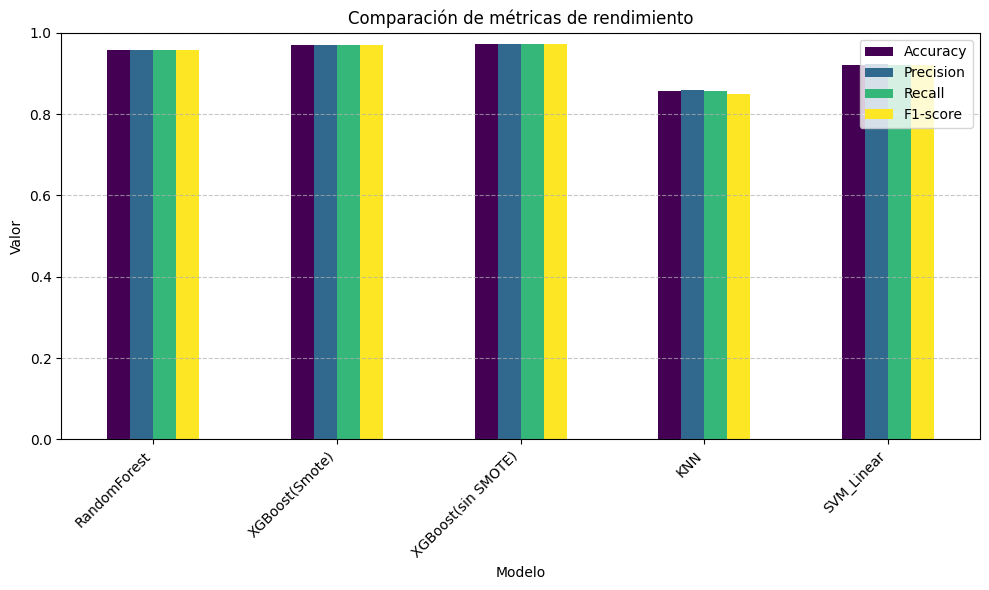

,Modelo,Accuracy,Precision,Recall,F1-score
0,RandomForest,0.958237,0.958911,0.958237,0.958226
1,XGBoost(Smote),0.969838,0.969995,0.969838,0.969718
2,XGBoost(sin SMOTE),0.972158,0.972096,0.972158,0.972012
3,KNN,0.856148,0.859168,0.856148,0.850265
4,SVM_Linear,0.921114,0.923676,0.921114,0.920226


In [ ]:
# Crear DataFrame de métricas comparativas
metrics_df = pd.DataFrame({
    'Modelo': ['RandomForest', 'XGBoost(Smote)', 'XGBoost(sin SMOTE)', 'KNN', 'SVM_Linear'],
    'Accuracy': [accuracy_score(y_test, pred_rf),
                 accuracy_score(y_test, pred_xgb),
                 accuracy_score(y_test, pred_xgb_simple),
                 accuracy_score(y_test, pred_knn), # Nuevo
                 accuracy_score(y_test, pred_svm)], # Nuevo
    'Precision': [precision_score(y_test, pred_rf, average='weighted'),
                  precision_score(y_test, pred_xgb, average='weighted'),
                  precision_score(y_test, pred_xgb_simple, average='weighted'),
                  precision_score(y_test, pred_knn, average='weighted'), # Nuevo
                  precision_score(y_test, pred_svm, average='weighted')], # Nuevo
    'Recall': [recall_score(y_test, pred_rf, average='weighted'),
               recall_score(y_test, pred_xgb, average='weighted'),
               recall_score(y_test, pred_xgb_simple, average='weighted'),
               recall_score(y_test, pred_knn, average='weighted'), # Nuevo
               recall_score(y_test, pred_svm, average='weighted')], # Nuevo
    'F1-score': [f1_score(y_test, pred_rf, average='weighted'),
                 f1_score(y_test, pred_xgb, average='weighted'),
                 f1_score(y_test, pred_xgb_simple, average='weighted'),
                 f1_score(y_test, pred_knn, average='weighted'), # Nuevo
                 f1_score(y_test, pred_svm, average='weighted')] # Nuevo
})

# Gráfico de barras comparativo
plt.figure(figsize=(10,6)) # Aumentar un poco el tamaño para más barras
metrics_df.set_index('Modelo').plot(kind='bar', ax=plt.gca(), colormap='viridis')
plt.title('Comparación de métricas de rendimiento')
plt.ylabel('Valor')
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right') # Rotar etiquetas para mejor visualización
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout() # Ajustar diseño
plt.show()

display(metrics_df)

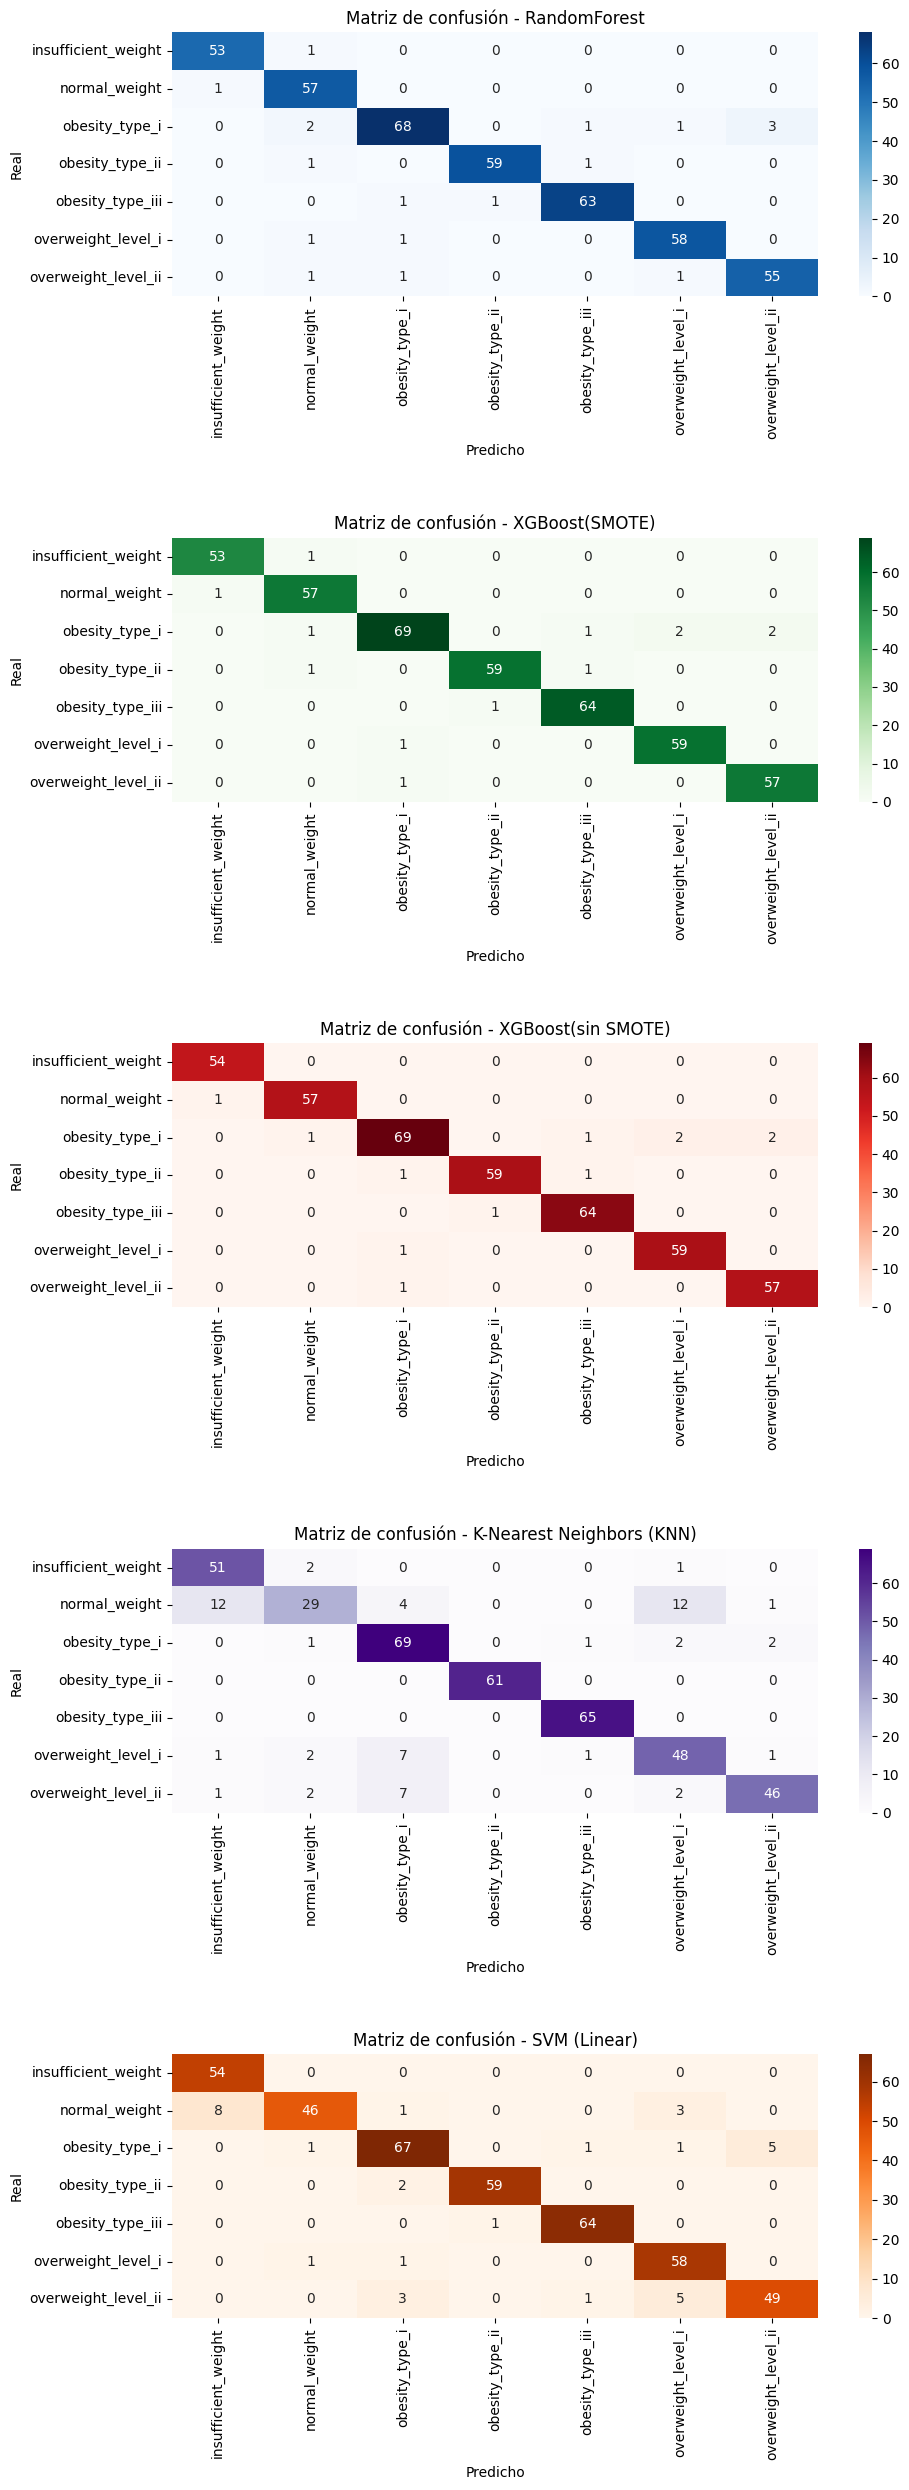

In [ ]:
# Matrices de confusión
fig, axes = plt.subplots(5, 1, figsize=(10, 25)) # Aumentamos el tamaño vertical (25) y el número de filas (5)

# RandomForest
sns.heatmap(confusion_matrix(y_test, pred_rf),
            annot=True,
            fmt='d',
            cmap='Blues',
            ax=axes[0],
            xticklabels=clases_reales,
            yticklabels=clases_reales)
axes[0].set_title('Matriz de confusión - RandomForest')
axes[0].set_xlabel('Predicho')
axes[0].set_ylabel('Real')

# XGBoost (SMOTE)
sns.heatmap(confusion_matrix(y_test, pred_xgb),
            annot=True, fmt='d',
            cmap='Greens',
            ax=axes[1],
            xticklabels=clases_reales,
            yticklabels=clases_reales)
axes[1].set_title('\n\nMatriz de confusión - XGBoost(SMOTE)')
axes[1].set_xlabel('Predicho')
axes[1].set_ylabel('Real')

# XGBoost (sin SMOTE)
sns.heatmap(confusion_matrix(y_test, pred_xgb_simple),
            annot=True, fmt='d',
            cmap='Reds',
            ax=axes[2],
            xticklabels=clases_reales,
            yticklabels=clases_reales)
axes[2].set_title('\n\nMatriz de confusión - XGBoost(sin SMOTE)')
axes[2].set_xlabel('Predicho')
axes[2].set_ylabel('Real')

# 4. KNN
sns.heatmap(confusion_matrix(y_test, pred_knn),
            annot=True, fmt='d',
            cmap='Purples',
            ax=axes[3],
            xticklabels=clases_reales,
            yticklabels=clases_reales)
axes[3].set_title('\n\nMatriz de confusión - K-Nearest Neighbors (KNN)')
axes[3].set_xlabel('Predicho')
axes[3].set_ylabel('Real')

# SVM_Linear
sns.heatmap(confusion_matrix(y_test, pred_svm),
            annot=True, fmt='d',
            cmap='Oranges',
            ax=axes[4],
            xticklabels=clases_reales,
            yticklabels=clases_reales)
axes[4].set_title('\n\nMatriz de confusión - SVM (Linear)')
axes[4].set_xlabel('Predicho')
axes[4].set_ylabel('Real')


plt.tight_layout()
plt.show()

In [ ]:
# Evaluar overfitting / underfitting
def evaluar_overfitting(modelo, X_train, X_test, y_train, y_test, nombre):
    """Calcula y muestra el gap de rendimiento entre train y test."""

    # Nota: Usamos el método .score() que es el accuracy en clasificación para pipelines
    train_score = modelo.score(X_train, y_train)
    test_score = modelo.score(X_test, y_test)
    gap = train_score - test_score

    print(f'\nModelo: {nombre}')
    print(f'  Score en entrenamiento: {train_score:.3f}')
    print(f'  Score en prueba:        {test_score:.3f}')
    print(f'  Diferencia (gap):       {gap:.3f}')

    if gap > 0.1:
        print("Posible sobreajuste (overfitting).")
    elif gap < -0.05:
        print("Posible bajoajuste (underfitting).")
    else:
        print("Ajuste adecuado (sin evidencia fuerte de over/underfitting).")

# Evaluación de los modelos originales
evaluar_overfitting(rf_pipe, X_train, X_test, y_train, y_test, "RandomForest")
evaluar_overfitting(best_xgb, X_train, X_test, y_train, y_test, "XGBoost (SMOTE)")
evaluar_overfitting(xgb_simple_pipe, X_train, X_test, y_train, y_test, "XGBoost (sin SMOTE)")
evaluar_overfitting(knn_pipe, X_train, X_test, y_train, y_test, "KNN")
evaluar_overfitting(svm_pipe, X_train, X_test, y_train, y_test, "SVM_Linear")


Modelo: RandomForest
  Score en entrenamiento: 0.992
  Score en prueba:        0.958
  Diferencia (gap):       0.034
Ajuste adecuado (sin evidencia fuerte de over/underfitting).

Modelo: XGBoost (SMOTE)
  Score en entrenamiento: 0.999
  Score en prueba:        0.970
  Diferencia (gap):       0.030
Ajuste adecuado (sin evidencia fuerte de over/underfitting).

Modelo: XGBoost (sin SMOTE)
  Score en entrenamiento: 0.999
  Score en prueba:        0.972
  Diferencia (gap):       0.027
Ajuste adecuado (sin evidencia fuerte de over/underfitting).

Modelo: KNN
  Score en entrenamiento: 0.901
  Score en prueba:        0.856
  Diferencia (gap):       0.045
Ajuste adecuado (sin evidencia fuerte de over/underfitting).

Modelo: SVM_Linear
  Score en entrenamiento: 0.943
  Score en prueba:        0.921
  Diferencia (gap):       0.022
Ajuste adecuado (sin evidencia fuerte de over/underfitting).


In [ ]:
# Verificar la URI de seguimiento
print(f"Tracking URI: {mlflow.get_tracking_uri()}")

Tracking URI: file:///content/mlruns


In [ ]:
!zip -r mlruns.zip mlruns/

  adding: mlruns/ (stored 0%)
  adding: mlruns/0/ (stored 0%)
  adding: mlruns/0/meta.yaml (deflated 24%)
  adding: mlruns/.trash/ (stored 0%)
  adding: mlruns/591922849470545044/ (stored 0%)
  adding: mlruns/591922849470545044/6723ab5f0be14ff68f3b9973b507cb23/ (stored 0%)
  adding: mlruns/591922849470545044/6723ab5f0be14ff68f3b9973b507cb23/params/ (stored 0%)
  adding: mlruns/591922849470545044/6723ab5f0be14ff68f3b9973b507cb23/params/model_type (stored 0%)
  adding: mlruns/591922849470545044/6723ab5f0be14ff68f3b9973b507cb23/params/n_neighbors (stored 0%)
  adding: mlruns/591922849470545044/6723ab5f0be14ff68f3b9973b507cb23/params/n_jobs (stored 0%)
  adding: mlruns/591922849470545044/6723ab5f0be14ff68f3b9973b507cb23/params/metric_params (stored 0%)
  adding: mlruns/591922849470545044/6723ab5f0be14ff68f3b9973b507cb23/params/smote_applied (stored 0%)
  adding: mlruns/591922849470545044/6723ab5f0be14ff68f3b9973b507cb23/params/p (stored 0%)
  adding: mlruns/591922849470545044/6723ab5f0be14

In [ ]:


files.download('mlruns.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

NGROK_AUTH_TOKEN = userdata.get('Ez_NGrok')

In [ ]:
# Asegúrate de que el token esté configurado
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Lanza el servidor MLflow en segundo plano
# (Asume que MLflow está guardando los runs en la carpeta 'mlruns' por defecto)
mlflow_command = "mlflow ui"
process = subprocess.Popen(mlflow_command.split(), stdout=subprocess.PIPE, stderr=subprocess.PIPE)

# Crea un túnel ngrok al puerto 5000 (puerto por defecto de MLflow)
public_url = ngrok.connect(5000)

print(f"MLflow UI disponible en: {public_url}")

MLflow UI disponible en: NgrokTunnel: "https://overvehement-loraine-subchorioid.ngrok-free.dev" -> "http://localhost:5000"
